In [2]:
import neal
import datetime
import pandas as pd
import fix_yahoo_finance as yf
import pandas_datareader.data as web
sampler = neal.SimulatedAnnealingSampler()

In [3]:
# Use NumPy and Bokeh for plotting
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

# Print the full anneal schedule
schedule = [[0.0,0.0], [50.0, 0.5], [250.0, 0.5], [300, 1.0]]
print("Schedule: %s" % schedule)

# Plot the anneal schedule
p = figure(title="Example Anneal Schedule with Pause", x_axis_label='Time [us]', y_axis_label='Annealing Parameter s')
p.line(*np.array(schedule).T)
show(p)

Loading BokehJS ...

Schedule: [[0.0, 0.0], [50.0, 0.5], [250.0, 0.5], [300, 1.0]]


In [4]:
schedule=[[0.0,0.0],[12.0,0.6],[12.8,1.0]]
print("Schedule: %s" % schedule)
p = figure(title="Example Anneal Schedule with Quench", x_axis_label='Time [us]', y_axis_label='Annealing Parameter s')
p.line(*np.array(schedule).T)
show(p)

Schedule: [[0.0, 0.0], [12.0, 0.6], [12.8, 1.0]]


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
schedule=[[0.0, 0.0], [40.0, 0.4], [90.0, 0.4], [91.2, 1.0]]
print("Schedule: %s" % schedule)
p = figure(title="Example Anneal Schedule with Pause and Quench", x_axis_label='Time [us]', y_axis_label='Annealing Parameter s')
p.line(*np.array(schedule).T)
show(p)

Schedule: [[0.0, 0.0], [40.0, 0.4], [90.0, 0.4], [91.2, 1.0]]


In [6]:
# Money that can be invested
Ai = 50
Aj = 50
# Total budget
B = 200

#Dictorionary J and h terms
J = {}
h = {}

def covariance(a,b):
    return a.cov(b)

def hi(name, price, returns, cov):

    # mean expected return
    E = np.mean(returns)

    # hi = -(1/2)((1/3)*cov(Ri,Ri) + (1/3)Ai^2 - (1/3)E(Ri) - 2B(1/3)*Ai)
    h_term = -0.5*((1/3)*cov + (1/3)* (Ai ** 2) - (1/3)* E - 2*B*(1/3)*Ai)
    h[name] = h_term

def Ji(name_i, name_j, cov):
    # Ji,j = -(1/4)((1/3)*cov(Ri,Rj) + (1/3)AiAj)
    coupler = -(0.25)*((1/3)*cov + ((1/3)*Ai*Aj))
    J[(name_i, name_j)] = coupler

start = datetime.datetime(2018,1,3)       
end = datetime.datetime(2021,1,1)
all_data = {ticker: web.get_data_yahoo(ticker,start,end)
          for ticker in ['AAPL','IBM','MSFT','GOOGL']}	  
price = pd.DataFrame({ticker:data['Adj Close']
                    for ticker,data in all_data.items()})
volume = pd.DataFrame({ticker:data['Volume']
                     for ticker,data in all_data.items()})
returns = price.pct_change()      #calculate the percentage of the price

returns = returns.dropna()

print('-' * 55)
print(returns.tail())
    
cov_apple = covariance(returns['AAPL'], returns['AAPL'])
print('-' * 55)
print(f' Sampleset sorted on energy')
cov_ibm = covariance(returns['IBM'], returns['IBM'])
cov_msft = covariance(returns['MSFT'], returns['MSFT'])
cov_google = covariance(returns['GOOGL'], returns['GOOGL'])

cov_apple_ibm = covariance(returns['AAPL'], returns['IBM'])
cov_ibm_microsoft = covariance(returns['IBM'], returns['MSFT'])
cov_microsoft_google = covariance(returns['MSFT'], returns['GOOGL'])
cov_google_apple = covariance(returns['GOOGL'], returns['AAPL'])
cov_apple_microsoft = covariance(returns['AAPL'], returns['MSFT'])
cov_ibm_google = covariance(returns['IBM'], returns['GOOGL'])

hi('apple', price['AAPL'],returns['AAPL'], cov_apple)
hi('ibm', price['IBM'],returns['IBM'], cov_ibm)
hi('microsoft', price['MSFT'],returns['MSFT'], cov_msft)
hi('google', price['GOOGL'],returns['GOOGL'], cov_google)

Ji('apple','ibm',cov_apple_ibm)
Ji('apple','microsoft',cov_apple_microsoft)
Ji('ibm','microsoft',cov_ibm_microsoft)
Ji('ibm','google',cov_ibm_google)
Ji('microsoft','google',cov_microsoft_google)
Ji('google','apple',cov_google_apple)

-------------------------------------------------------
                AAPL       IBM      MSFT     GOOGL
Date                                              
2020-12-24  0.007712  0.006376  0.007827  0.003431
2020-12-28  0.035766  0.001043  0.009921  0.022951
2020-12-29 -0.013315 -0.008172 -0.003601 -0.009132
2020-12-30 -0.008527  0.004362 -0.011019 -0.012237
2020-12-31 -0.007703  0.012385  0.003338  0.009440
-------------------------------------------------------
 Sampleset sorted on energy


In [8]:
h = {0: 1.0, 1: -1.0, 2: -1.0, 3: 1.0, 4: 1.0, 5: -1.0, 6: 0.0, 7: 1.0,
     8: 1.0, 9: -1.0, 10: -1.0, 11: 1.0, 12: 1.0, 13: 0.0, 14: -1.0, 15: 1.0}
J = {(9, 13): -1, (2, 6): -1, (8, 13): -1, (9, 14): -1, (9, 15): -1,
     (10, 13): -1, (5, 13): -1, (10, 12): -1, (1, 5): -1, (10, 14): -1,
     (0, 5): -1, (1, 6): -1, (3, 6): -1, (1, 7): -1, (11, 14): -1,
     (2, 5): -1, (2, 4): -1, (6, 14): -1}

In [9]:
runs=1000
import neal
sampler = neal.SimulatedAnnealingSampler()
results = sampler.sample_ising(h, J, 
    num_reads=runs,
    answer_mode='raw',
    label='Notebook - Anneal Schedule',
    annealing_time=100)

print("QPU time used:", results.info, "microseconds.")
print(results)

QPU time used: {'beta_range': [0.13862943611198905, 4.605170185988092], 'beta_schedule_type': 'geometric'} microseconds.
     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 energy num_oc.
0   -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -20.0       1
1   -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -20.0       1
7   -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -20.0       1
8   -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -20.0       1
11  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -20.0       1
15  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -20.0       1
23  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -20.0       1
25  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -20.0       1
27  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -20.0       1
28  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -20.0       1
33  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -20.0       1
41  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -20.0       1
42  -1 -

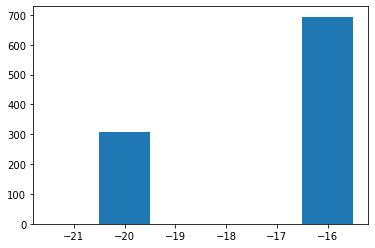

In [10]:
plt.hist(results.record.energy,rwidth=1,align='left',bins=[-21,-20,-19,-18,-17,-16,-15])
plt.show()

In [11]:
_, counts = np.unique(results.record.energy.reshape(1000,1), axis=0, return_counts=True)
print("Ground state probability: ", counts[0]/runs)

Ground state probability:  0.306


In [13]:
import json
with open("files/saved_pause_results.json", "r") as read_file:
    saved_pause_success_prob = pd.read_json(json.load(read_file))

In [14]:
from itertools import cycle

# set up some plot decoration values
all_colors = ["dodgerblue", "orange", "darkorchid"]
all_lines = ["4 1 4", "4 4", "4 0"]
all_markers = ["circle", "square", "triangle", "diamond"]

p = figure(title="Såuccess fraction using pause for a range of anneal schedule parameters",
           x_axis_label='s at pause start',
           y_axis_label='ground state fraction',
           y_axis_type='log',
           y_range=[1e-3, 0.65],
           plot_height=960,
           plot_width=960)

colors = cycle(all_colors)
lines = cycle(all_lines)
for anneal,a_group in saved_pause_success_prob.groupby('anneal_time'):
    col = next(colors)
    line = next(lines)
    
    markers = cycle(all_markers)
    for pause,p_group in a_group.groupby('pause_duration'):
        marker = next(markers)
        legend = "anneal={}, pause={}".format(anneal,pause)
        
        x = p_group["s_feature"]
        y = p_group["success_frac"]
        p.line(x, y, legend=legend, color=col, line_dash=line, line_width=2)
        p.scatter(x, y, legend=legend, color=col, marker=marker, size=8)
    
p.legend.location = "top_left"
show(p)

In [15]:
#Update the standard anneal schedule parameters below: 

anneal_time = 10.0
pause_duration = 500.0      # Must be greater than 0
pause_start = 0.4        # Must be between 0 and 1

#----------------------------------------------------------------
#Leave the code below to run the problem and display the results.
#----------------------------------------------------------------
schedule=[[0.0,0.0],[pause_start*anneal_time,pause_start],[pause_start*anneal_time+pause_duration, pause_start],[anneal_time+pause_duration, 1.0]]
runs=900
results = sampler.sample_ising(h, J,
                anneal_schedule=schedule,
                num_reads=runs, 
                answer_mode='raw',
                label='Notebook - Anneal Schedule',                        
                num_spin_reversal_transforms=1)
success = np.count_nonzero(results.record.energy == -20.0)/runs
print("Success probability: ",success)

p.scatter([pause_start],[success], color="red")
show(p)

Success probability:  0.27555555555555555


In [16]:
with open("files/saved_quench_results.json", "r") as read_file:
    saved_quench_success_prob = pd.read_json(json.load(read_file))

In [17]:
p = figure(title="Success fraction using quench for a range of anneal schedule parameters",
           x_axis_label='s at quench start',
           y_axis_label='ground state fraction',
           y_axis_type='log',
           y_range=[1e-4, 0.5],
           plot_height=960,
           plot_width=960)

colors = cycle(all_colors)
lines = cycle(all_lines)
for anneal,a_group in saved_quench_success_prob.groupby('anneal_time'):
    col = next(colors)
    line = next(lines)
   
    markers = cycle(all_markers)
    for quench,p_group in a_group.groupby('quench_slope'):
        marker = next(markers)
        legend = "anneal={}, quench slope={}".format(anneal,quench)
        
        x = p_group["s_feature"]
        y = p_group["success_frac"]
        p.line(x, y, legend=legend, color=col, line_dash=line, line_width=2)
        p.scatter(x, y, legend=legend, color=col, marker=marker, size=8)

p.legend.location = "top_left"
show(p)

In [18]:
#Update the standard anneal schedule parameters below 

anneal_time = 50.0
quench_slope = 1.0      # Must be greater than 0
quench_start = 0.2      # Must be between 0 and 1

#----------------------------------------------------------------
#Leave the code below to run the problem and display the results.
#----------------------------------------------------------------
schedule=[[0.0,0.0],[quench_start*anneal_time,quench_start],[(1-quench_start+quench_slope*quench_start*anneal_time)/quench_slope, 1.0]]
runs=950
results = sampler.sample_ising(h, J,
                anneal_schedule=schedule,
                num_reads=runs, 
                answer_mode='raw',
                label='Notebook - Anneal Schedule',
                num_spin_reversal_transforms=1)
success = np.count_nonzero(results.record.energy == -20.0)/runs
print("Success probability: ",success)

p.scatter([quench_start],[success], color="red")
show(p)

Success probability:  0.27789473684210525
